In [1]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm

2025-11-03 23:11:42.695709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762186302.764853    1081 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762186302.784621    1081 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762186302.960033    1081 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762186302.960069    1081 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762186302.960072    1081 computation_placer.cc:177] computation placer alr

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/home/pomp/miniconda3/envs/tf/lib/python3.9/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.23) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.keras.backend.clear_session()

In [4]:
model = tf.keras.models.load_model('./eyeclss003.keras')

I0000 00:00:1762186313.319038    1081 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,358 (8.67 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 10,250 (40.04 KB)

In [6]:
test_dir = './splited/test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=1,
    image_size=(256, 256),
    seed=982314,
)

Found 511 files belonging to 4 classes.


In [7]:
correct_labels = []
predicted_labels = []

class_names = ["ctrct", "diabret", "glua", "norm"]
# class_names = sorted(os.listdir(test_dir))

for i, batch in enumerate(tqdm(test_ds)):
    image, label = batch[0][0], batch[1][0]

    img_array = tf.keras.utils.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model(img_array, verbose=0)
    
    choice = np.argmax(predictions[0])

    predicted_class = class_names[choice]
    confidence = round(100*(choice), 0)
    
    
    actual_class = class_names[label]

    correct_labels.append(actual_class)
    predicted_labels.append(predicted_class)

100%|██████████| 511/511 [01:11<00:00,  7.14it/s]


In [8]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
print(classification_report(correct_labels, predicted_labels))
print(f"accuracy : {accuracy_score(correct_labels, predicted_labels)}")

              precision    recall  f1-score   support

       ctrct       0.91      0.94      0.92       126
     diabret       0.97      0.96      0.97       133
        glua       0.87      0.85      0.86       122
        norm       0.88      0.88      0.88       130

    accuracy                           0.91       511
   macro avg       0.91      0.91      0.91       511
weighted avg       0.91      0.91      0.91       511

accuracy : 0.9080234833659491


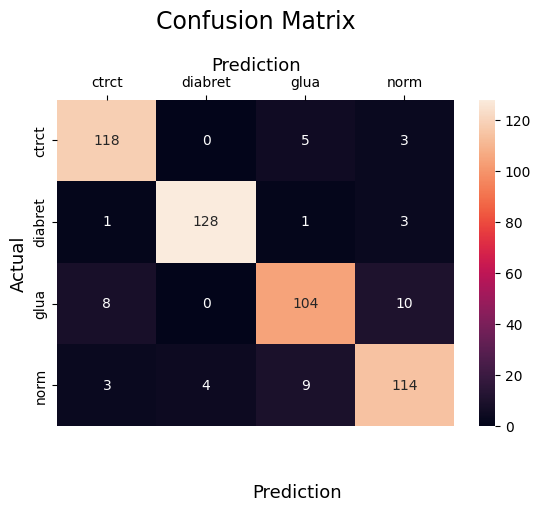

In [10]:
cm = confusion_matrix(correct_labels, predicted_labels)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=class_names,
            yticklabels=class_names)

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()